In [48]:

import cv2
import numpy as np
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from timm.models import create_model
import torch.nn.functional as F
import torchvision.transforms as transforms 
import os
import torch.nn as nn
from timm_vis.methods import *

In [3]:
# Wrapper from https://github.com/huggingface/pytorch-image-models/discussions/1232
def my_forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 1:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward

In [4]:
def max_center_crop(image):
    width, height = image.size
    size = min(width, height)
    left = (width - size) // 2
    top = (height - size) // 2
    right = (width + size) // 2
    bottom = (height + size) // 2
    return image.crop((left, top, right, bottom))

In [47]:
# Choose dataset, image, model to test
datasets = ["HumanLba", "MouseLba", "CellInclusion", "Glomeruli", "Necrosis", "ProliferativePattern", "Lung", "Breast"]
datasets_classes = [9,8,2,2,2,2,10,2]
index = 2
class_id = 1

dataset = datasets[index]
num_classes = datasets_classes[index]

model_name = "vit_small_patch16_224"
ckpt_path = f"./../../../result/comparison/output{index+1}/{dataset}_vits16.ckpt"

cnn_name = "densenet201"
cnn_ckpt_path = f"./../../../result/comparison/output{index+1}/{dataset}_dense201.ckpt"

folder_path = f"./../../../datasets/{dataset}/test/{class_id}/"
img_path = os.path.join(folder_path, os.listdir(folder_path)[20])

In [49]:
# load the image and transform it
img = Image.open(img_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(img)
img = max_center_crop(img)

model = create_model(model_name, pretrained=False, num_classes=num_classes)
cnn_model = create_model(cnn_name, pretrained=False, num_classes=num_classes)
# load the checkpoint
if torch.cuda.is_available():
    checkpoint = torch.load(ckpt_path)
    cnn_checkpoint = torch.load(cnn_ckpt_path)
else:
    checkpoint = torch.load(ckpt_path, map_location=(torch.device('cpu')))
    cnn_checkpoint = torch.load(cnn_ckpt_path, map_location=(torch.device('cpu')))

# load the state of the model from the 'blocks' module
blocks_state_dict = {k.replace('model.', ''): v for k, v in checkpoint['state_dict'].items() if k.startswith('model.')}
model.load_state_dict(blocks_state_dict, strict=False)
cnn_blocks_state_dict = {k.replace('model.', ''): v for k, v in cnn_checkpoint['state_dict'].items() if k.startswith('model.')}
cnn_model.load_state_dict(cnn_blocks_state_dict, strict=False)

# use the wrapper
for layer in model.blocks :
    layer.attn.forward = my_forward_wrapper(layer.attn)

# set the model to evaluation mode
model.eval()
cnn_model.eval()
input_tensor = input_tensor.unsqueeze(0)
y = model(input_tensor)
cnn_y = model(input_tensor)
print(f"ViT prediction: {y.argmax(dim=1).item()}")
print(f"CNN prediction: {cnn_y.argmax(dim=1).item()}")

ViT prediction: 1
CNN prediction: 1


In [69]:
# From https://github.com/novice03/timm-vis/blob/main/timm_vis/methods.py
acts = [0]
grads = [0]

module = cnn_model.features.transition3[-1]

def f_hook(self, input, output):
    acts[0] = output

def b_hook(self, grad_in, grad_out):
    grads[0] = grad_out

h1 = module.register_forward_hook(f_hook)
h2 = module.register_backward_hook(b_hook)

outs = cnn_model(input_tensor)
h1.remove()
h2.remove()
outs[0, class_id].backward()

gap = torch.mean(grads[0][0].view(grads[0][0].size(0), grads[0][0].size(1), -1), dim = 2)
acts = acts[0][0]
gradcam = torch.nn.ReLU()(torch.sum(gap[0].reshape((gap.size()[1], 1, 1)) * acts, dim = 0))
arr = transforms.Resize((img.size[1], img.size[0]))(gradcam.unsqueeze(0))
gradcam_img = arr.detach().cpu().permute((1, 2, 0)).squeeze(-1)
gradcam_norm = (gradcam_img - gradcam_img.min()) / (gradcam_img.max() - gradcam_img.min())
cnn_heatmap = plt.cm.hot(gradcam_norm)



In [74]:
# Inspired by https://github.com/jeonsworld/ViT-pytorch

att_maps = []
for layer in model.blocks :
    attn_map = layer.attn.attn_map
    att_maps.append(attn_map)

att_mat = torch.stack(att_maps).squeeze(1)
print(att_mat.shape)
# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = (mask - np.min(mask)) / (mask.max() - mask.min())
mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
# Apply the heatmap color map to the attention mask
heatmap = plt.cm.hot(mask)
# Overlay the heatmap on the input image
result = np.squeeze(heatmap[:, :, :3])

torch.Size([12, 6, 197, 197])


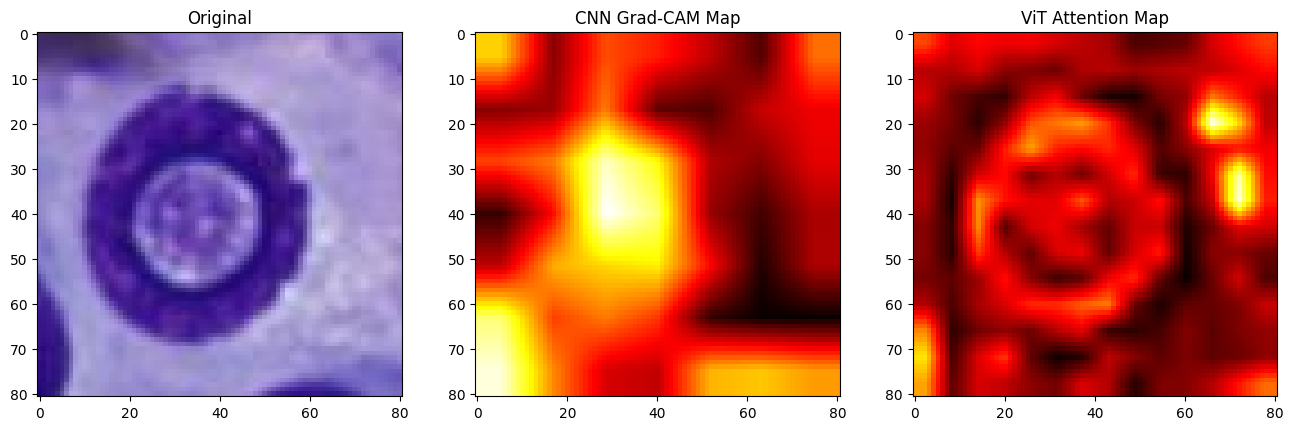

In [75]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('CNN Grad-CAM Map')
ax3.set_title('ViT Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(cnn_heatmap)
_ = ax3.imshow(result)

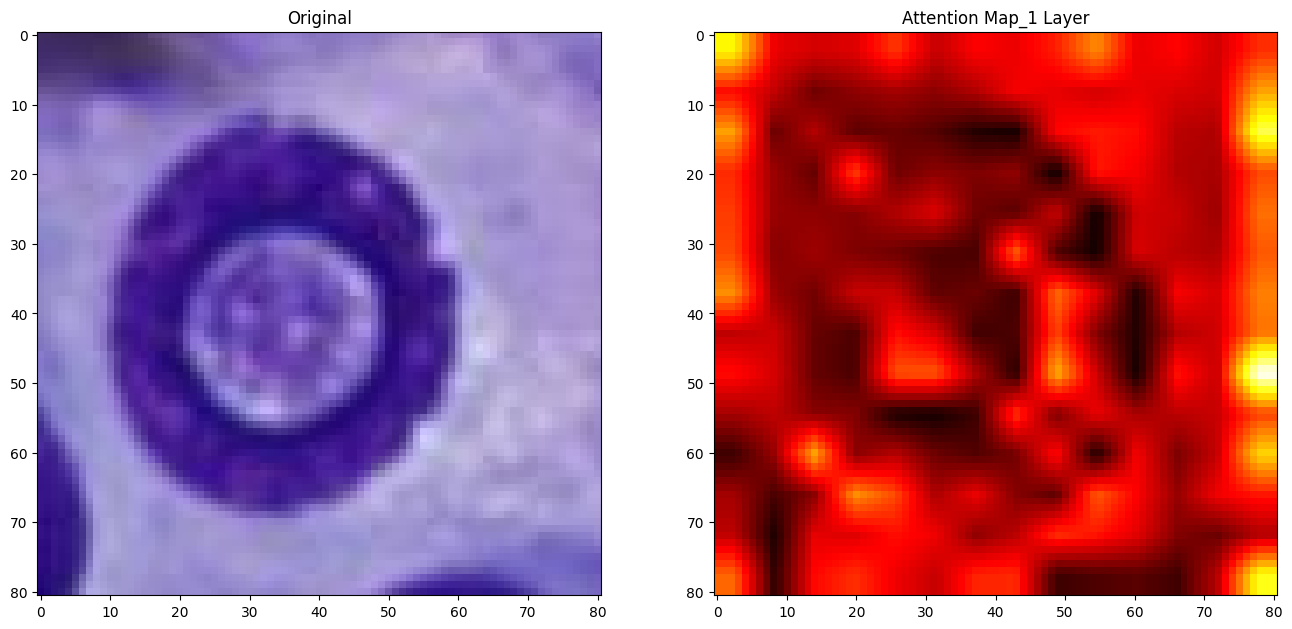

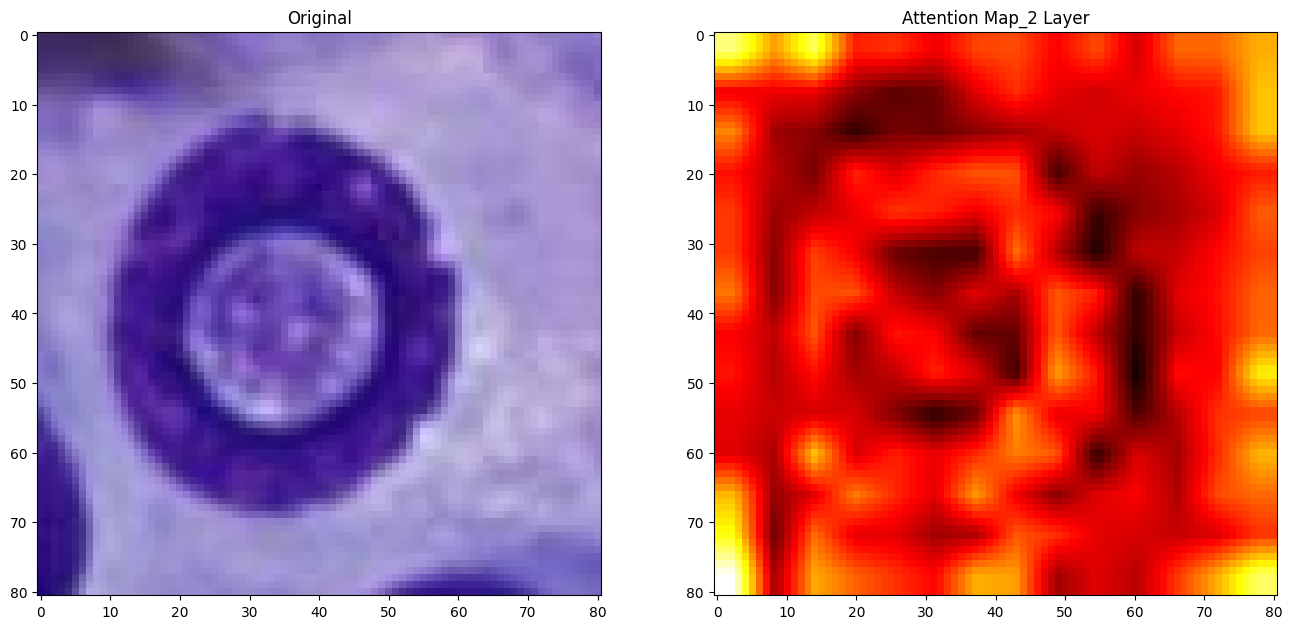

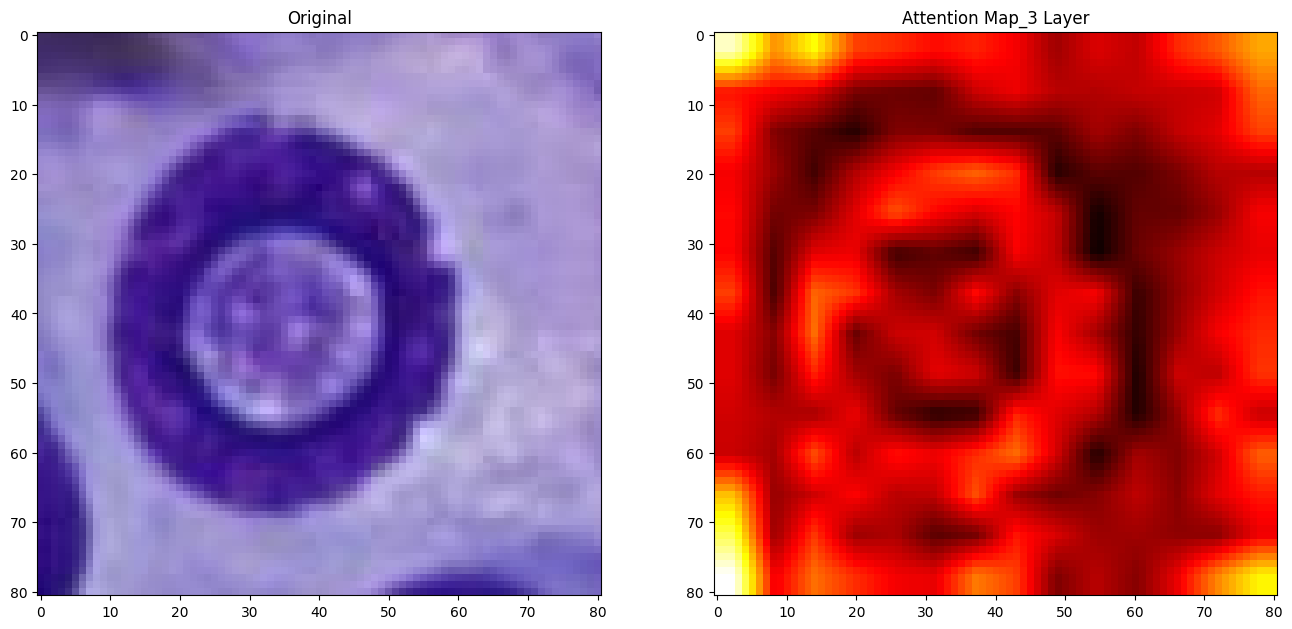

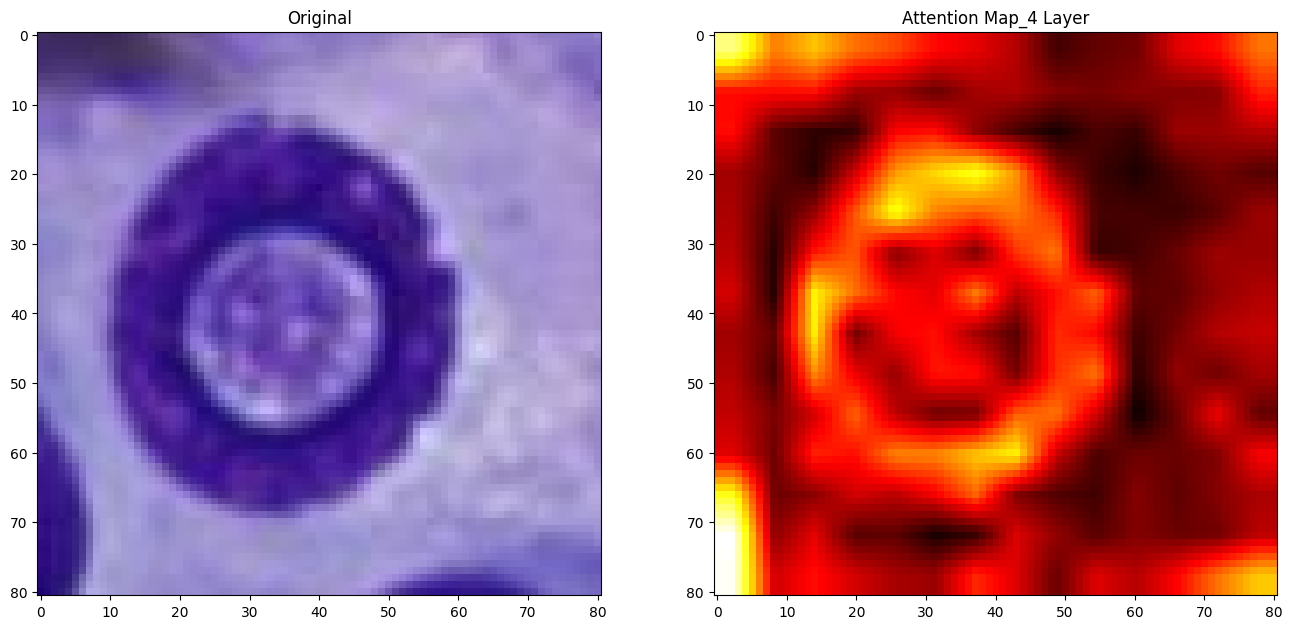

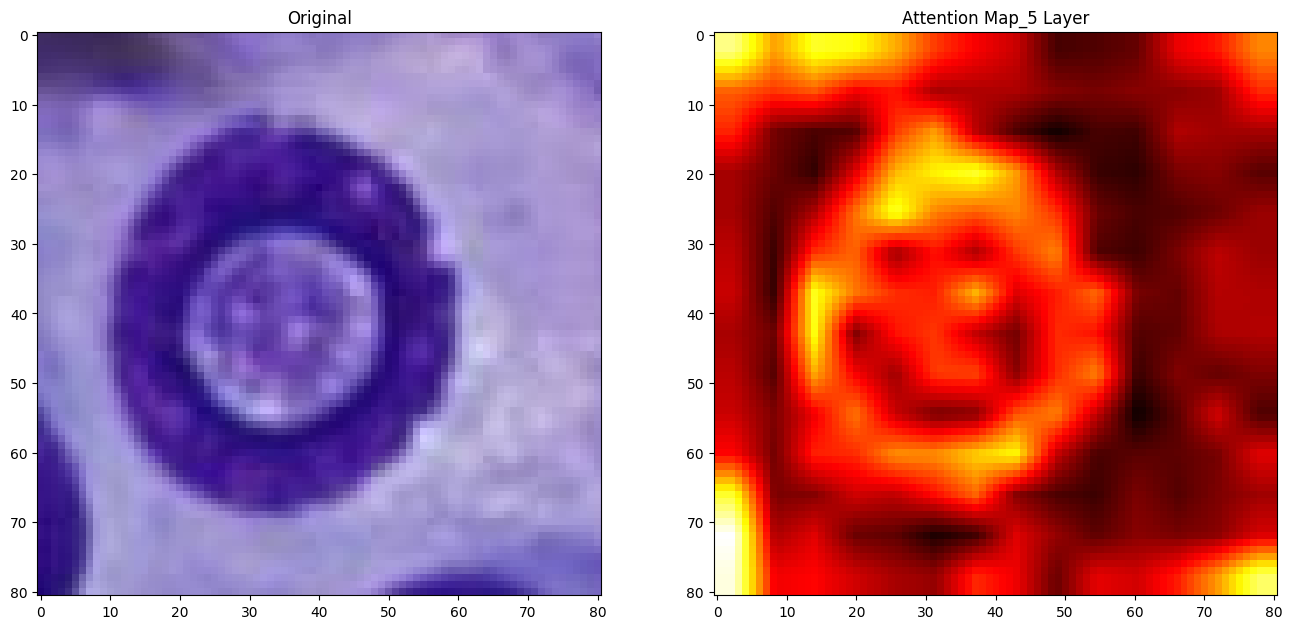

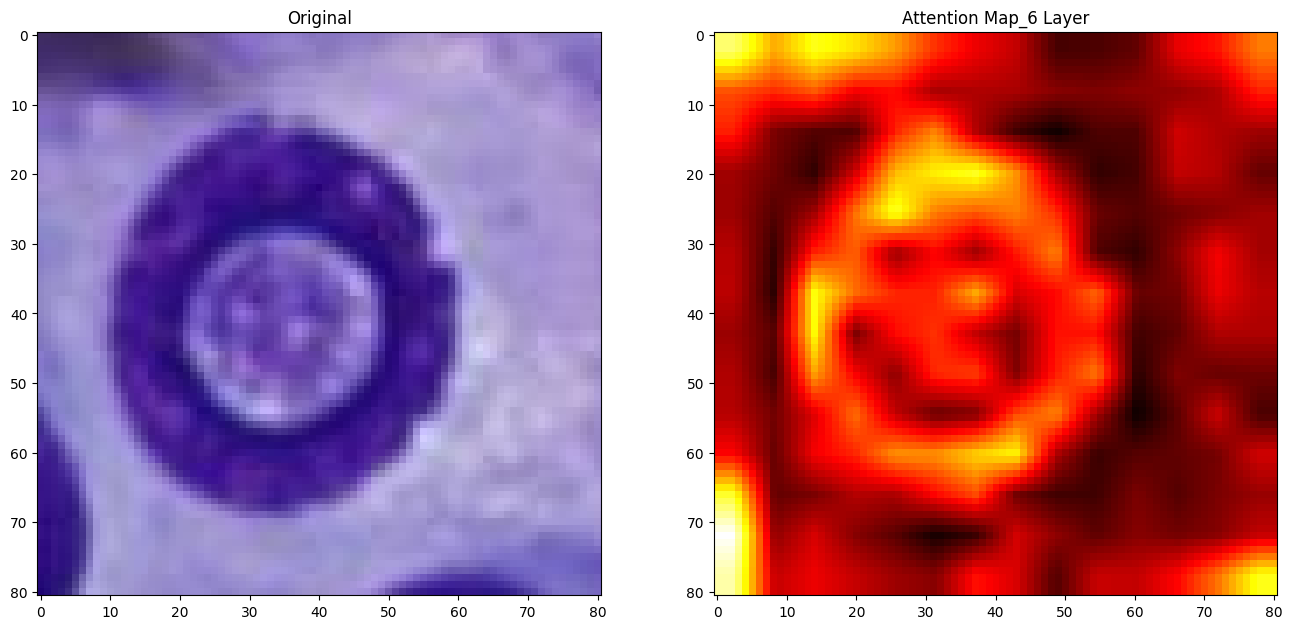

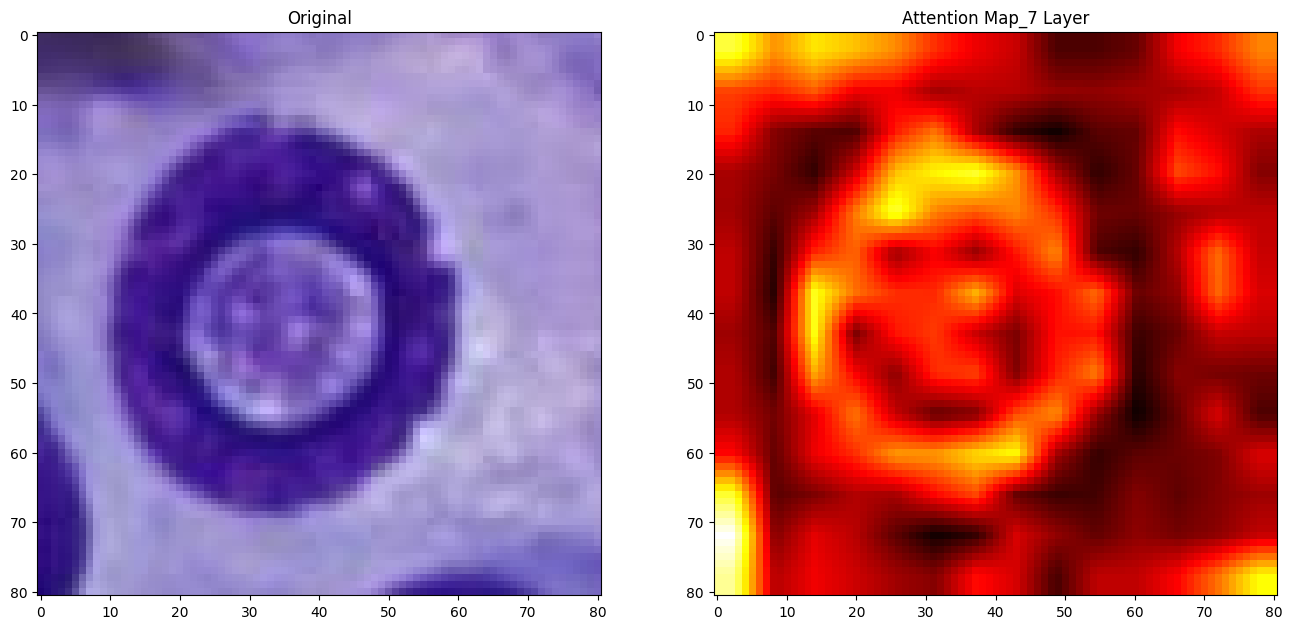

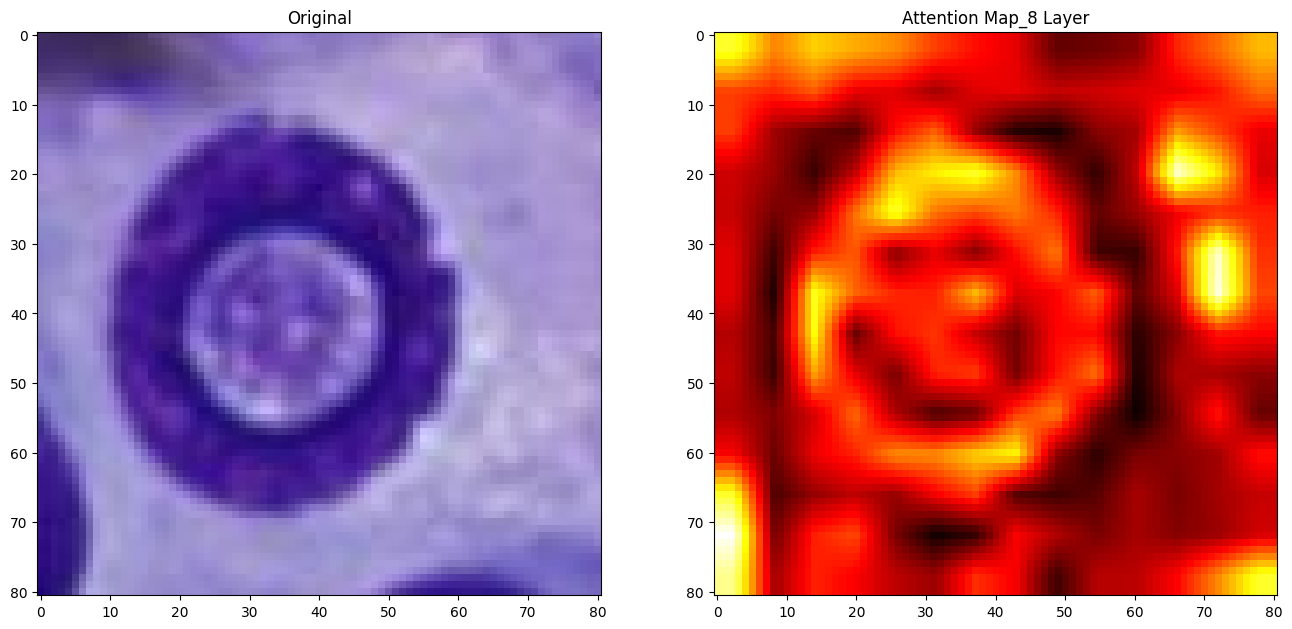

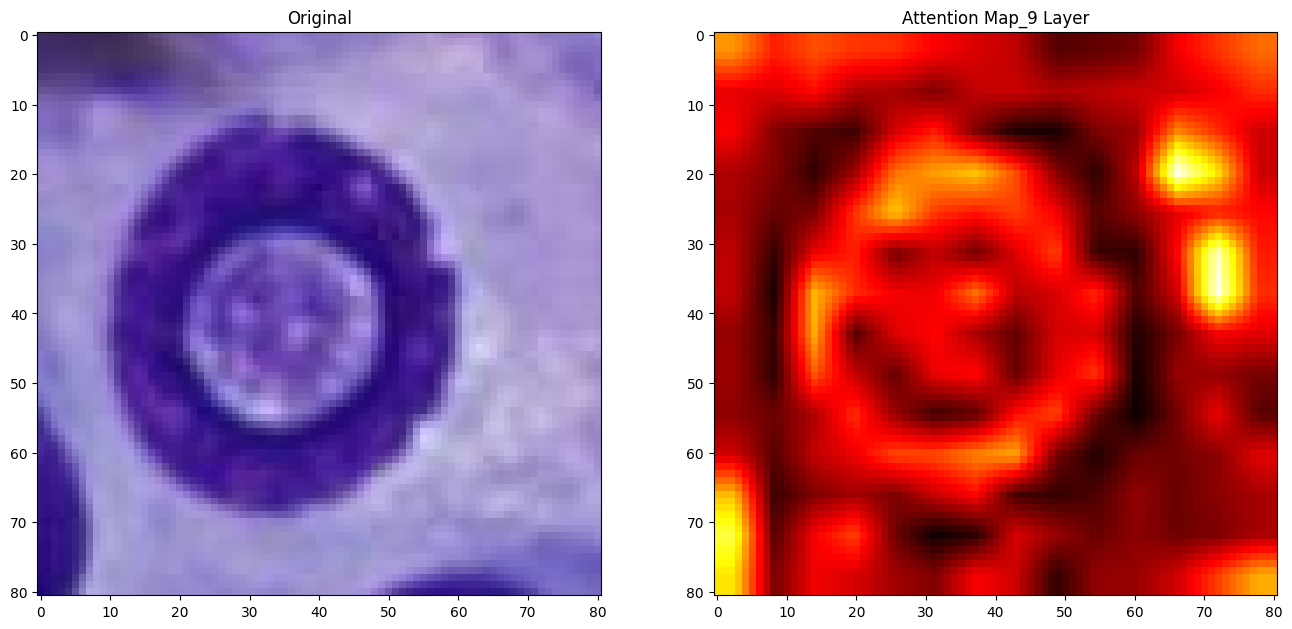

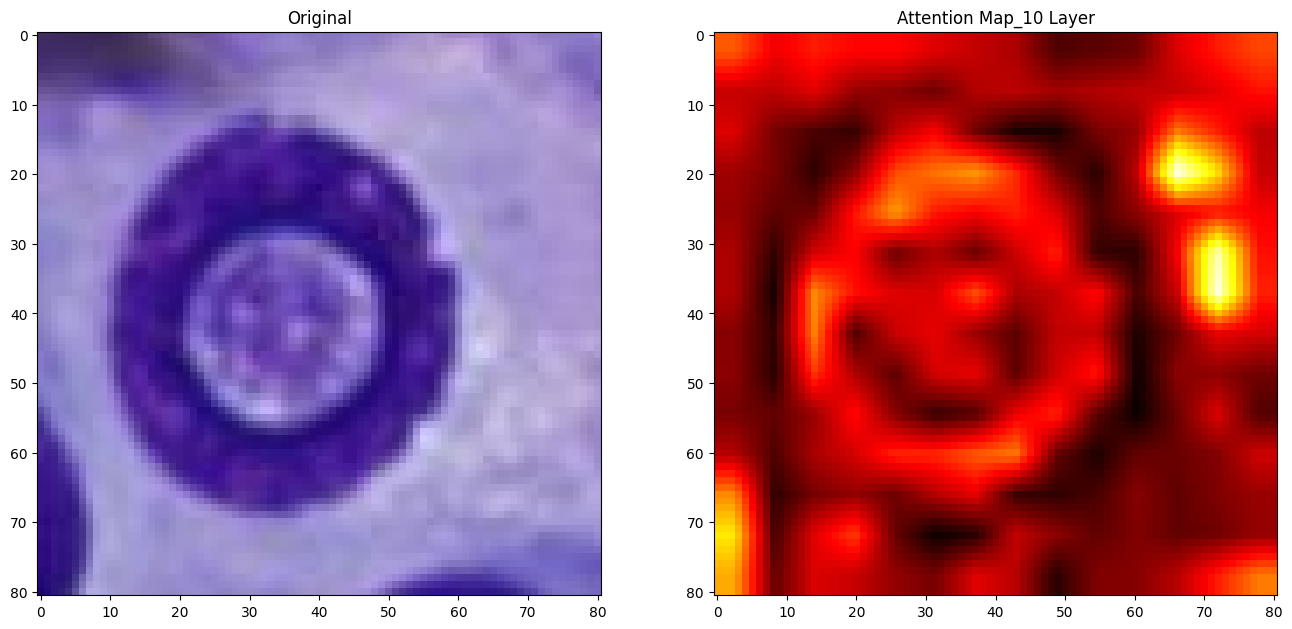

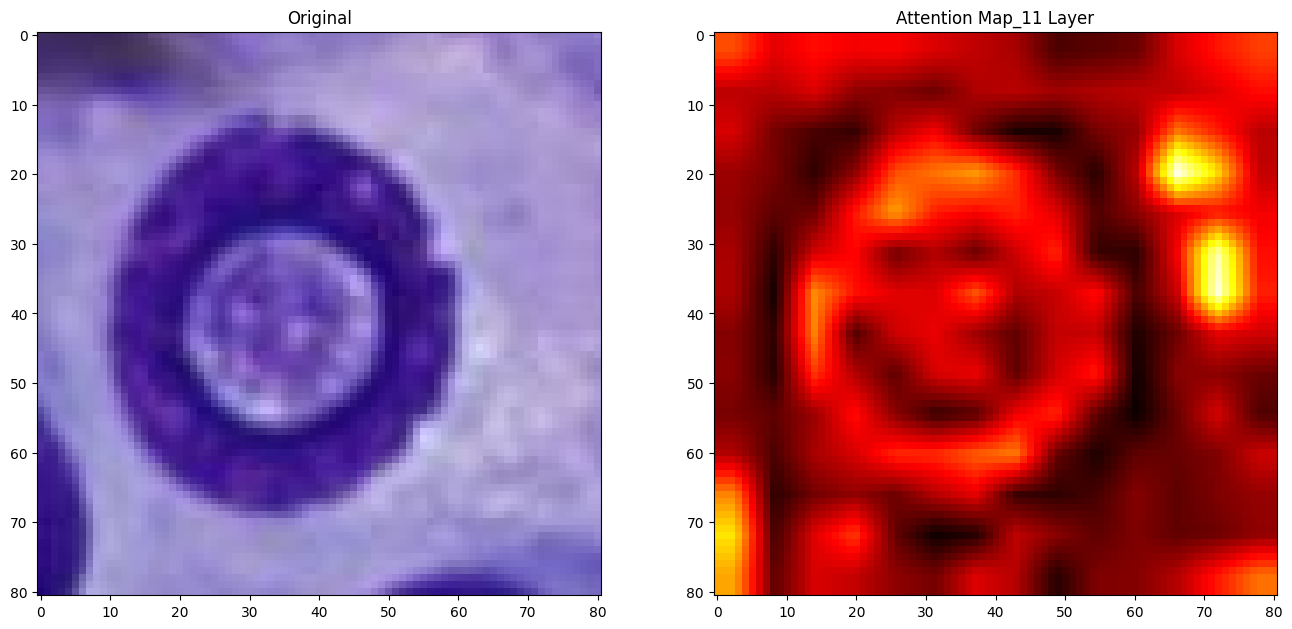

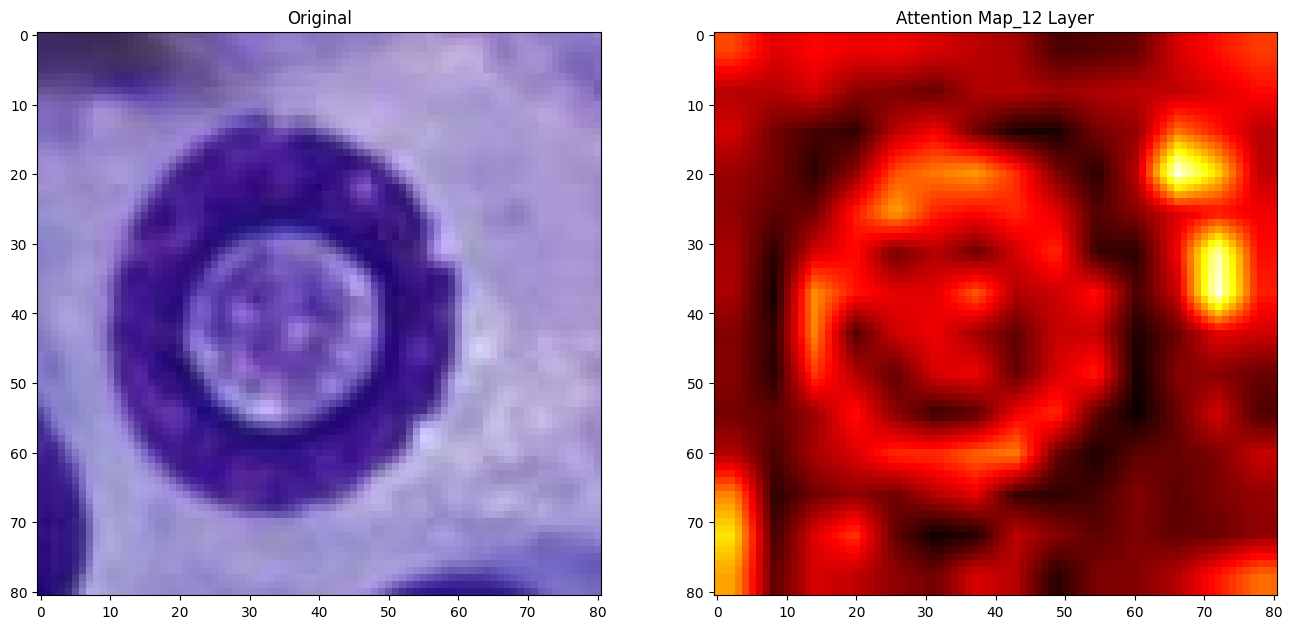

In [76]:
# Code from [...] 

for i, v in enumerate(joint_attentions):
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = (mask - np.min(mask)) / (mask.max() - mask.min())
    mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
    # Apply the heatmap color map to the attention mask
    heatmap = plt.cm.hot(mask)
    # Overlay the heatmap on the input image
    result = np.squeeze(heatmap[:, :, :3])

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map_%d Layer' % (i+1))
    _ = ax1.imshow(img)
    _ = ax2.imshow(result)

